
## Subject 2: Text NewsGroup Classification
1. Download the newsgroups data set using the code below. 
2. Construct a text classifier that predicts the target variable (newsgroups.target) from the input data (newsgroups.data).
3. We will evaluate your classifier against a hold-out data set, so be sure to construct a classification function that can receive a single string.



In [1]:
import functools
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os as os
import re 
from nltk.stem.snowball import SnowballStemmer
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.metrics import classification_report
from sklearn.pipeline import Pipeline
from sklearn.datasets import fetch_20newsgroups

In [2]:
#Download the newsgroups data
#It consists of different articles


def get_news_dataset():

  newsgroups_train = fetch_20newsgroups(subset='train')
  newsgroups_test = fetch_20newsgroups(subset='test')
  print(newsgroups_train.data[:9])

  X = newsgroups_train.data+newsgroups_test.data
  y = np.concatenate([newsgroups_train.target,newsgroups_test.target])
  print(newsgroups_train.target_names)
  newsgroups_train.target[:9]

  #dublam numarul de valori pentru am vazut ca unele tipuri de articole apar doar o singura data,
  #si vom avea erori daca vom incerca sa generam o regresie liniara( trebuie minim doua tipuri de articole de acelasi target)
  X=X+X
  y = np.concatenate([y,y])
  
  #we'll use some more data for training than it is customary :)
  #it's a hard problem
  return train_test_split(X,y,test_size=0.2,random_state=7)



train_text,test_text,train_target,test_target = get_news_dataset()
print(test_target)


["From: lerxst@wam.umd.edu (where's my thing)\nSubject: WHAT car is this!?\nNntp-Posting-Host: rac3.wam.umd.edu\nOrganization: University of Maryland, College Park\nLines: 15\n\n I was wondering if anyone out there could enlighten me on this car I saw\nthe other day. It was a 2-door sports car, looked to be from the late 60s/\nearly 70s. It was called a Bricklin. The doors were really small. In addition,\nthe front bumper was separate from the rest of the body. This is \nall I know. If anyone can tellme a model name, engine specs, years\nof production, where this car is made, history, or whatever info you\nhave on this funky looking car, please e-mail.\n\nThanks,\n- IL\n   ---- brought to you by your neighborhood Lerxst ----\n\n\n\n\n", "From: guykuo@carson.u.washington.edu (Guy Kuo)\nSubject: SI Clock Poll - Final Call\nSummary: Final call for SI clock reports\nKeywords: SI,acceleration,clock,upgrade\nArticle-I.D.: shelley.1qvfo9INNc3s\nOrganization: University of Washington\nLines: 1

In [3]:
#Define the preprocessing functions

html_detector = re.compile('<.*?>',flags=re.UNICODE)
punctuation_detector = re.compile('[\W_ ]',flags=re.UNICODE)  #keep spaces and alpanumeric characters

def drop_html(texts):
  return [re.sub(html_detector,' ',text) for text in texts]

def to_lowercase(texts):
  return [text.lower() for text in texts]

def drop_punctuation(texts):
  return [re.sub(punctuation_detector,' ',text) for text in texts]

def tokenize(texts):
  #here one can get smarter (e.g. wordpiece tokenizer)
  #we'll tokenize based on just the whitespace
  return [text.split(" ") for text in texts]

def drop_whitespaces(texts):
  #assume that the texts are already tokenized
  return [[word for word in text if not word.isspace() and len(word)>0 ] for text in texts]

stemmer = SnowballStemmer('english')
def stem(texts):
  #assume that the texts are already tokenized
  return [[stemmer.stem(word) for word in text] for text in texts]

def identity(x):
  return x

def compose(functions):
    return functools.reduce(lambda f, g: lambda x: f(g(x)), functions, lambda x: x)

def get_preprocessing_pipeline():
  steps = [stem,drop_whitespaces,tokenize,to_lowercase,drop_punctuation,drop_html]
  return compose(steps)

In [4]:
#perform the preprocessing
#it takes quite some time, but we'll do it just once

preprocessing_pipeline = get_preprocessing_pipeline()
preprocessed_train = preprocessing_pipeline(train_text)
preprocessed_test = preprocessing_pipeline(test_text)

In [5]:
#encode the sentiments of the reviews

label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(train_target)
y_test = label_encoder.transform(test_target)
print(test_target[:10])

[ 6 13 15  2  2 18 12 10 15 11]


In [36]:
#let's get a baseline
#we'll see if we can improve performance

vectorizer = TfidfVectorizer()
X_train = vectorizer.fit_transform(train_text)
X_test = vectorizer.transform(test_text)

classifier = LogisticRegression().fit(X_train,y_train,1)
print(classification_report(y_test,classifier.predict(X_test)))

              precision    recall  f1-score   support

           0       0.97      0.94      0.95       311
           1       0.92      0.96      0.94       407
           2       0.93      0.95      0.94       383
           3       0.90      0.93      0.91       373
           4       0.95      0.96      0.96       416
           5       0.97      0.95      0.96       391
           6       0.89      0.92      0.91       412
           7       0.97      0.95      0.96       399
           8       0.99      0.98      0.98       375
           9       0.99      0.98      0.99       394
          10       0.99      1.00      1.00       420
          11       0.98      0.96      0.97       390
          12       0.95      0.95      0.95       409
          13       0.99      0.98      0.98       413
          14       0.97      0.99      0.98       390
          15       0.96      0.98      0.97       380
          16       0.98      0.98      0.98       361
          17       1.00    

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [6]:
#what if we use the preprocessed text

vectorizer = TfidfVectorizer(tokenizer=identity,preprocessor=identity)
X_train = vectorizer.fit_transform(preprocessed_train)
X_test = vectorizer.transform(preprocessed_test)

classifier = LogisticRegression().fit(X_train,y_train)
print(classification_report(y_test,classifier.predict(X_test)))

C:\Users\bledig\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\bledig\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


              precision    recall  f1-score   support

           0       0.96      0.91      0.93       311
           1       0.91      0.94      0.92       407
           2       0.92      0.95      0.93       383
           3       0.87      0.90      0.88       373
           4       0.95      0.94      0.95       416
           5       0.98      0.95      0.96       391
           6       0.88      0.92      0.90       412
           7       0.97      0.95      0.96       399
           8       0.98      0.98      0.98       375
           9       0.99      0.98      0.98       394
          10       0.98      1.00      0.99       420
          11       0.97      0.97      0.97       390
          12       0.94      0.94      0.94       409
          13       0.99      0.98      0.98       413
          14       0.97      0.98      0.98       390
          15       0.92      0.98      0.95       380
          16       0.96      0.97      0.97       361
          17       1.00    

In [ ]:
# what happens if we do hyperparameter optimization?
# for hyperparamater search across multiple models see http://www.davidsbatista.net/blog/2018/02/23/model_optimization/
# we will assume our model is TfIdf + LogisticRegression and try to get best hyperparameters for it
# note that we could also search through preprocessing configurations
# Go ahead and try using CountVectorizer , LinearSVC, Multinomial Naive Bayes
# NLTK is an extensive python library for language processing; explore it

pipeline = Pipeline(steps=[
    ('tf_idf',TfidfVectorizer()),
    ('lr',LogisticRegression())
])

param_grid = {
    'tf_idf__max_features': [10000],
    'tf_idf__ngram_range': [(1,1),(1,2)],
    'tf_idf__preprocessor':[identity], #we did our own preprocessing and tokenizing
    'tf_idf__tokenizer':[identity],    #we ask tf-idf to not do anything in this regard
    'lr__C': [0.1,1]
}

best_clf = GridSearchCV(pipeline, param_grid, cv=2,scoring='accuracy') #should use something like cv ~=10
best_clf = best_clf.fit(preprocessed_train,y_train)

print(classification_report(y_test,best_clf.predict(preprocessed_test)))

Dupa cum am observat, prima metoda(LogisticRegression), a dat cele mai bune aproximari

## Subject 1: MNIST Clustering

1. Download the MNIST data set using the code below.
2. Ignoring the label normally associated to the dataset, construct a clustering of the data. Your clustering should maximize the v-score measure relative to true data labels (
    Paper describing the measure: https://www.aclweb.org/anthology/D07-1043.pdf
    Implementation available in python: https://scikit learn.org/stable/modules/generated/sklearn.metrics.v_measure_score.html#sklearn.metrics.v_measure_score
). Note that failing to ignore the labels during training will void your score for this subject.

*Also printed the silhouette value for a point is a measure of how similar that point is to points in its own cluster, when compared to points in other clusters.

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
['5' '0' '4' ... '4' '5' '6']


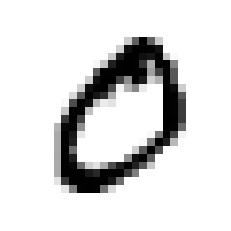

For n_clusters = 2 The average silhouette_score is : 0.08705025365093069
For n_clusters = 3 The average silhouette_score is : 0.054225671220494584
For n_clusters = 4 The average silhouette_score is : 0.06045907810451576
For n_clusters = 5 The average silhouette_score is : 0.06696012337809015
For n_clusters = 6 The average silhouette_score is : 0.06539732851014843
For n_clusters = 7 The average silhouette_score is : 0.06664587777060102
For n_clusters = 8 The average silhouette_score is : 0.07337929746295425
For n_clusters = 10 The average silhouette_score is : 0.055889444235506874


In [ ]:
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.metrics.cluster import v_measure_score
from matplotlib.cm import binary

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
from sklearn.datasets import fetch_openml

rand_state = 8
X, y = fetch_openml('mnist_784', version=1, return_X_y=True)
print(X), print(y)
range_n_clusters = [2,3,4,5,6,7,8,10,11,12,13,14,15]

some_digit_image = X[1].reshape(28, 28)
plt.imshow(some_digit_image, cmap=binary, interpolation="nearest")
plt.axis('off')
plt.show()

X_norm=X/255. #normalization

(fig,axes) = plt.subplots(1,len(range_n_clusters))
fig.set_size_inches(18, 10)
current_axis = 0;
v_score=[]

for n_clusters in range_n_clusters:
    
    axes[current_axis].set_xlim([-0.1, 1])
    axes[current_axis].set_ylim([0, len(X) + (n_clusters + 1) * 10])

    clusterer = KMeans(n_clusters=n_clusters, random_state=rand_state)
    cluster_labels = clusterer.fit_predict(X)
    v_score.append(v_measure_score(y, clusterer.labels_))

    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)
    
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        axes[current_axis].fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        axes[current_axis].text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    axes[current_axis].set_title("Silhouette plot for %d clusters"%n_clusters)
    axes[current_axis].set_xlabel("Silhouette coefficient values")
    axes[current_axis].set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    axes[current_axis].axvline(x=silhouette_avg, color="red", linestyle="--")
    axes[current_axis].set_yticks([])
    axes[current_axis].set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
    current_axis = current_axis+1
    plt.suptitle("Silhouette analysis for KMeans clustering on sample data",
                 fontsize=14, fontweight='bold')
    
print("Clusters")
print(dict(zip(range(6,12),v_score)))
plt.plot(range_n_clusters,v_score,'-ob')


Din analiza de mai sus tragem conluzia ca datele de mai sus contin 8 clusteri, deoacere pt 8 clusteri avem cea mai mare valoare pentru "v_measure_score" si anume 8: 0.506, dar deasemenea si valoarea de 11 clusteri are o valoare destul de mare(11: 0.502) 